In [2121]:
import numpy as np
import pandas as pd
from pandas.api.types import is_object_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from xgboost import XGBRegressor

In [2122]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format

In [2123]:
train=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/test.csv')
sample_submission=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/sample_submission.csv')

In [2124]:
train=train.drop(columns=['Alley', 'PoolQC','Fence', 'MiscFeature','GarageArea', 'MSSubClass'])
test=test.drop(columns=['Alley', 'PoolQC','Fence', 'MiscFeature','GarageArea', 'MSSubClass'])
y=train['SalePrice'].to_numpy()
train.drop(columns=['SalePrice'], inplace=True)

In [2127]:
print(train.shape)
print(test.shape)

(1460, 74)
(1459, 74)


In [2128]:
nonnumeric_features=[]
for col in train.columns:
    if is_object_dtype(train[col]):
        nonnumeric_features.append(col)
nonnumeric_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [2129]:
train.columns

Index(['Id', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'Encl

In [2130]:
train[nonnumeric_features].describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,NaN,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,NaN,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,NaN,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,NaN,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,NaN,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,WD,Normal


In [2131]:
train.loc[:, ~train.columns.isin(nonnumeric_features)].describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.00,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1379.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,730.50,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,46.55,567.24,1057.43,1162.63,346.99,5.84,1515.46,0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1978.51,1.77,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82
std,421.61,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33
min,1.00,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00
25%,365.75,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,1129.50,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1961.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00
50%,730.50,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,0.00,477.50,991.50,1087.00,0.00,0.00,1464.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,1980.00,2.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00
75%,1095.25,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,0.00,808.00,1298.25,1391.25,728.00,0.00,1776.75,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2002.00,2.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00
max,1460.00,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,1474.00,2336.00,6110.00,4692.00,2065.00,572.00,5642.00,3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,2010.00,4.00,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00


In [2132]:
with open('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/data_description.txt', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
#         if any(feature in line for feature in ['LotFrontage', 'MasVnrType', 'FireplaceQu']):
        if 'BsmtFinSF1' in line:
            print(line)
            for j in range(i+1, min(i+10, len(lines))):
                print(lines[j])

BsmtFinSF1: Type 1 finished square feet



BsmtFinType2: Rating of basement finished area (if multiple types)



       GLQ	Good Living Quarters

       ALQ	Average Living Quarters

       BLQ	Below Average Living Quarters	

       Rec	Average Rec Room

       LwQ	Low Quality

       Unf	Unfinshed



In [2133]:
nonnumeric_features.extend(['Id',
                            'BsmtFullBath'
                            ])

In [2135]:
nonnumeric_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'Id',
 'BsmtFullBath']

In [2136]:
zero_data_set_sum_train=train.isnull().sum()
zero_data_set_percentage_train=train.isnull().sum()/train.shape[0]*100
zero_data_set_train=pd.DataFrame({'sum':zero_data_set_sum_train, 'percentage': zero_data_set_percentage_train})
zero=zero_data_set_train.loc[zero_data_set_train['sum']>0]

In [2137]:
zero

,sum,percentage
LotFrontage,259,17.74
MasVnrType,872,59.73
MasVnrArea,8,0.55
BsmtQual,37,2.53
BsmtCond,37,2.53
BsmtExposure,38,2.60
BsmtFinType1,37,2.53
BsmtFinType2,38,2.60
Electrical,1,0.07
FireplaceQu,690,47.26


In [2138]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value=-999)
column_to_impute_train=[]
for i in range(len(zero.index)):
    column_to_impute_train.append(zero.index[i])
for col in column_to_impute_train:
    imputed_column = imputer.fit_transform(train[[col]])
    train[[col]] = imputed_column

In [2139]:
zero_data_set_sum_test=test.isnull().sum()
zero_data_set_percentage_test=test.isnull().sum()/test.shape[0]*100
zero_data_set_test=pd.DataFrame({'sum':zero_data_set_sum_test, 'percentage': zero_data_set_percentage_test})
zero2=zero_data_set_test.loc[zero_data_set_test['sum']>0]
zero2

,sum,percentage
MSZoning,4,0.27
LotFrontage,227,15.56
Utilities,2,0.14
Exterior1st,1,0.07
Exterior2nd,1,0.07
MasVnrType,894,61.27
MasVnrArea,15,1.03
BsmtQual,44,3.02
BsmtCond,45,3.08
BsmtExposure,44,3.02


In [2140]:
column_to_impute_test=[]
for i in range(len(zero2.index)):
    column_to_impute_test.append(zero2.index[i])
for col in column_to_impute_test:
    imputed_column = imputer.fit_transform(test[[col]])
    test[[col]] = imputed_column

In [2141]:
with open('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/data_description.txt', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
#         if any(feature in line for feature in ['LotFrontage', 'MasVnrType', 'FireplaceQu']):
        if 'PoolArea' in line:
            print(line)
            for j in range(i+1, min(i+10, len(lines))):
                print(lines[j])

PoolArea: Pool area in square feet



PoolQC: Pool quality

		

       Ex	Excellent

       Gd	Good

       TA	Average/Typical

       Fa	Fair

       NA	No Pool

		



In [2145]:
test['BsmtFullBath']=test['BsmtFullBath'].astype(int)

In [2147]:
train[nonnumeric_features]=train[nonnumeric_features].astype('category')
test[nonnumeric_features]=test[nonnumeric_features].astype('category')

In [2149]:
numeric_features=[]
for col in train.columns:
    if is_numeric_dtype(train[col]):
        numeric_features.append(col)
    else:
        pass
print(numeric_features)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>],
       [<Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>],
       [<Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'KitchenAbvGr'}>,
        <Axes: title={'center': 'TotR

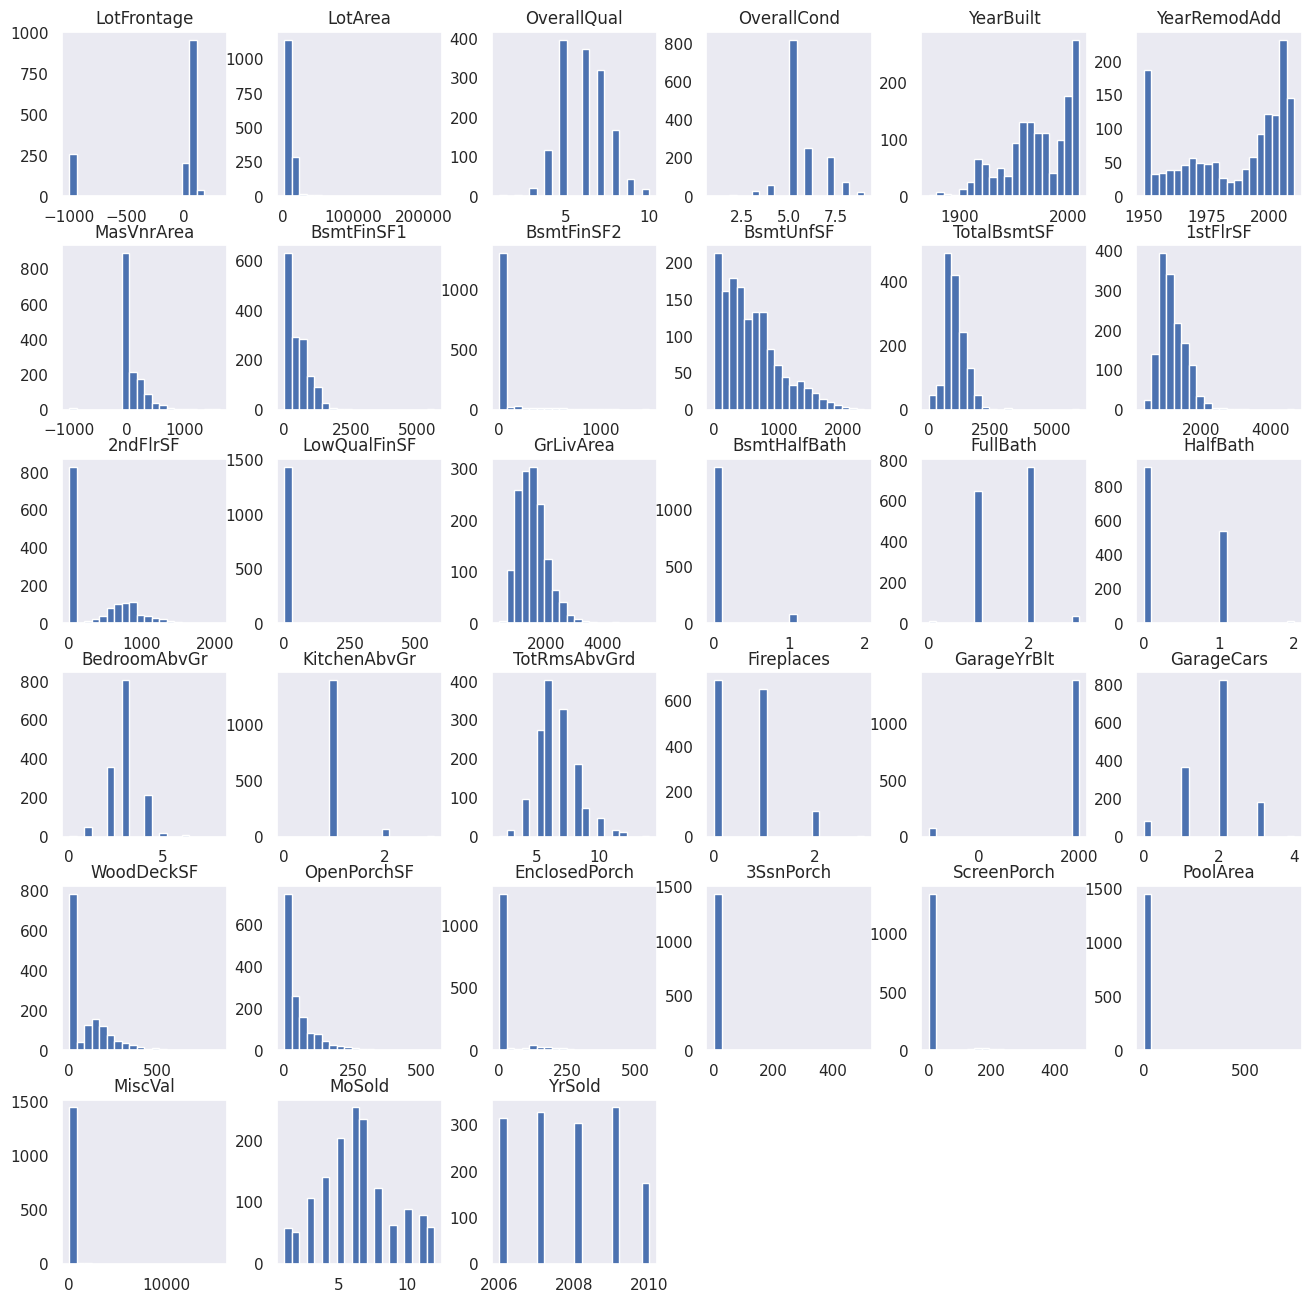

In [2151]:
train.hist(figsize=(16,16), bins=20, grid=False)

In [2152]:
train[numeric_features].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [2153]:
train.loc[train['PoolArea']>0, 'PoolArea']=train.loc[train['PoolArea']>0, 'PoolArea']=1
test.loc[test['PoolArea']>0, 'PoolArea']=test.loc[test['PoolArea']>0, 'PoolArea']=1


In [2154]:
# for col in numeric_features:
#     print(train[col].value_counts())

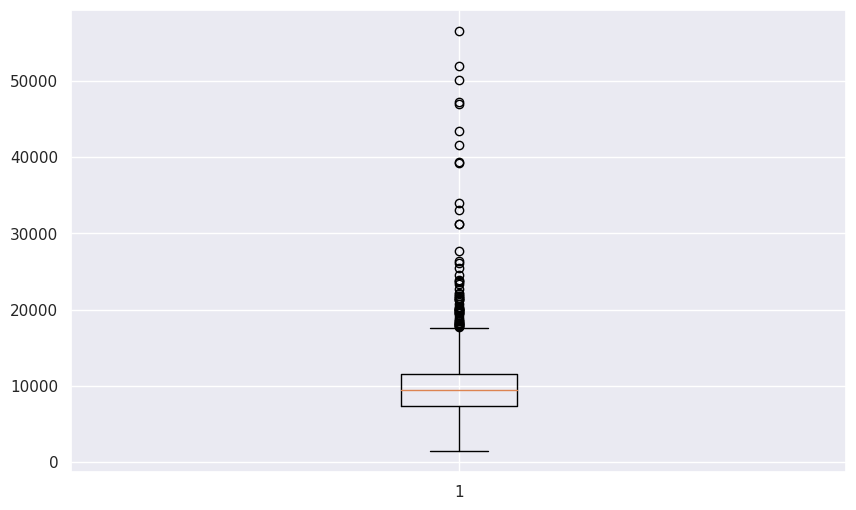

In [2155]:
plt.figure(figsize=(10,6))
plt.boxplot(test['LotArea'], showfliers=True)
plt.show()

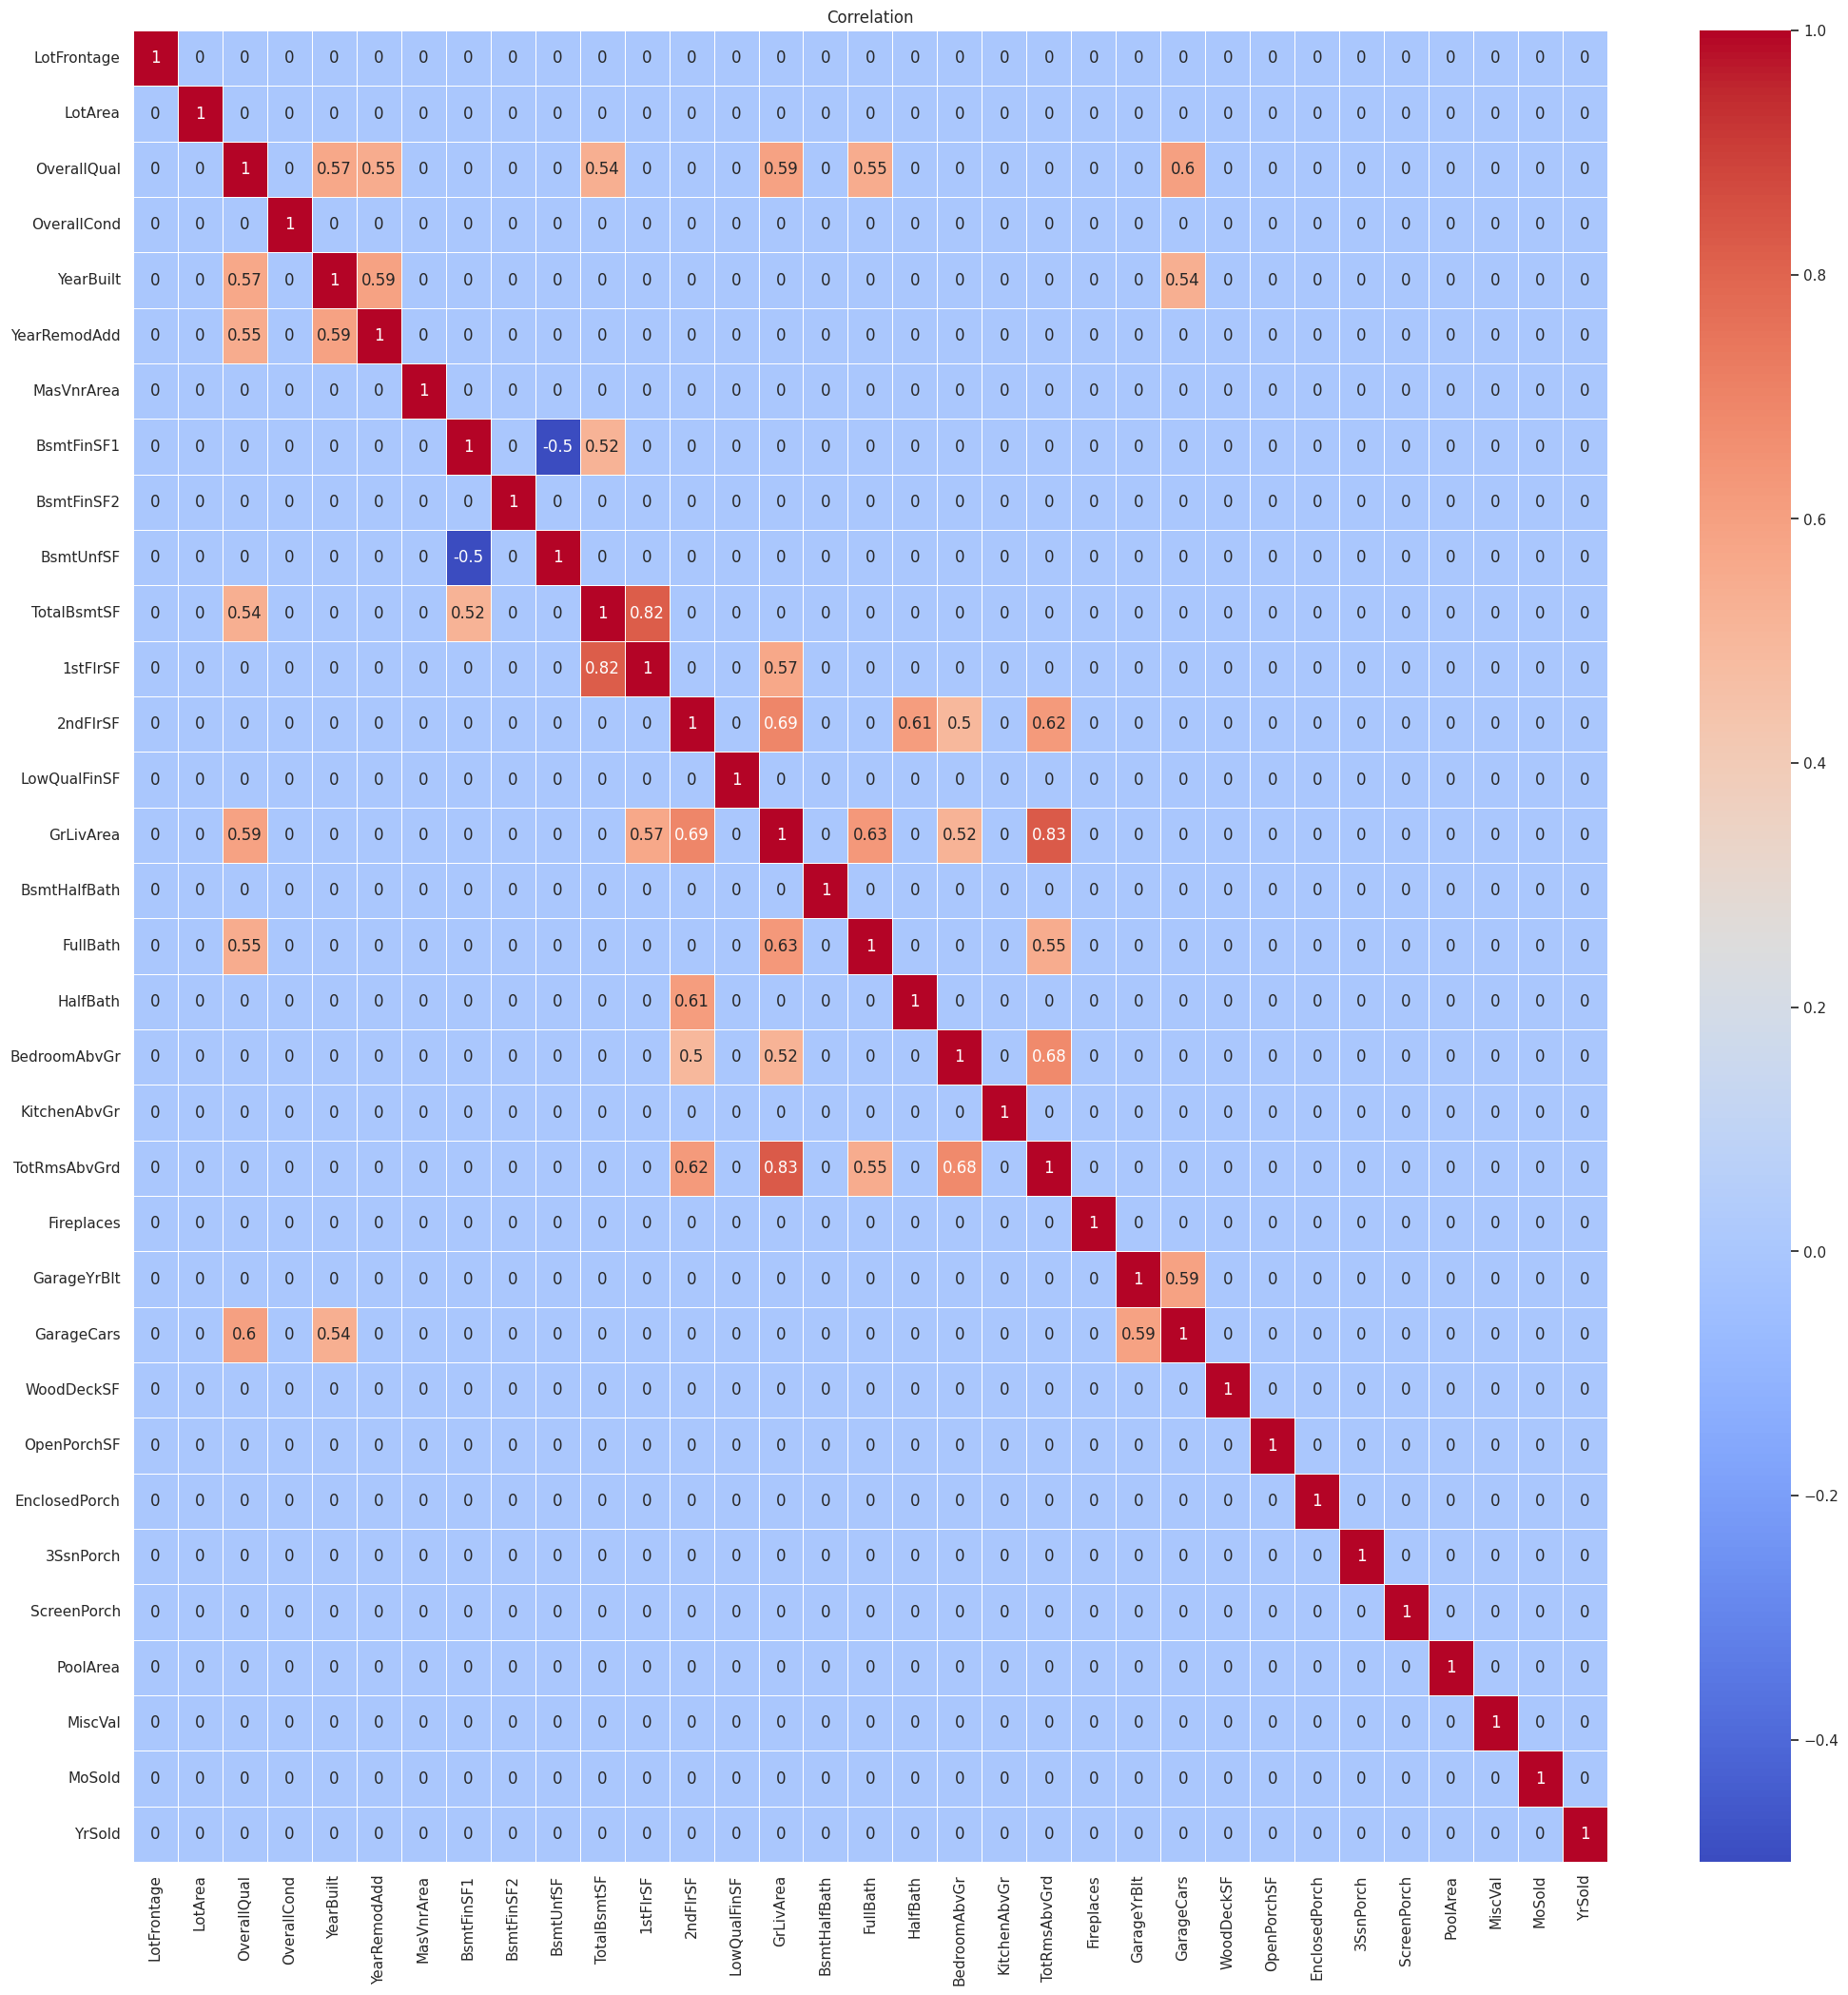

In [2156]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=train[numeric_features].corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.5]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [2157]:
train[numeric_features].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [2158]:
with open('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/data_description.txt', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
#         if any(feature in line for feature in ['LotFrontage', 'MasVnrType', 'FireplaceQu']):
        if 'MiscVal' in line:
            print(line)
            for j in range(i+1, min(i+10, len(lines))):
                print(lines[j])

MiscVal: $Value of miscellaneous feature



MoSold: Month Sold (MM)



YrSold: Year Sold (YYYY)



SaleType: Type of sale

		

       WD 	Warranty Deed - Conventional

       CWD	Warranty Deed - Cash



In [2159]:
for col in numeric_features:
    train[col]=train[col].astype(str)
    test[col]=test[col].astype(str)

In [2160]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.1, random_state=2)

In [2161]:
print(train.shape)
print(test.shape)
print(y.shape)
# print(y_test.shape)

(1460, 74)
(1459, 74)
(1460,)


In [2162]:
import catboost as cb
train_dataset = cb.Pool(train,y,
                        cat_features=nonnumeric_features
)                                                     
# test_dataset = cb.Pool(x_test,y_test,          
#                        cat_features=nonnumeric_features)

In [2163]:
from catboost import CatBoostRegressor
CAT=cb.CatBoostRegressor(metric_period=100,
                        #  eval_metric='RMSE',
                         task_type='GPU',
                         iterations=1500, 
                         learning_rate=0.04,
                        #  early_stopping_rounds = 50,
                         depth=8
                        )
CAT.fit(train_dataset,
        # eval_set=test_dataset
)

0:	learn: 77297.6182577	total: 101ms	remaining: 2m 32s
100:	learn: 24345.7948856	total: 8.74s	remaining: 2m 1s
200:	learn: 20039.0849916	total: 16.8s	remaining: 1m 48s
300:	learn: 18159.9676157	total: 24.3s	remaining: 1m 36s
400:	learn: 17370.6080284	total: 32.2s	remaining: 1m 28s
500:	learn: 16843.4876784	total: 40.3s	remaining: 1m 20s
600:	learn: 16366.0223286	total: 48.3s	remaining: 1m 12s
700:	learn: 15811.5635937	total: 56.2s	remaining: 1m 4s
800:	learn: 15399.5472625	total: 1m 3s	remaining: 55.4s
900:	learn: 15073.5540833	total: 1m 11s	remaining: 47.2s
1000:	learn: 14733.3717942	total: 1m 18s	remaining: 39.2s
1100:	learn: 14506.4094954	total: 1m 26s	remaining: 31.2s
1200:	learn: 14292.6938861	total: 1m 33s	remaining: 23.3s
1300:	learn: 14099.0802723	total: 1m 40s	remaining: 15.4s
1400:	learn: 14007.4524509	total: 1m 48s	remaining: 7.67s
1499:	learn: 13916.9405424	total: 1m 56s	remaining: 0us


In [2164]:
feature_importance = CAT.get_feature_importance(train_dataset)
feature_names = train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

feature_importance_df

,Feature,Importance
44,GrLivArea,23.25
15,OverallQual,18.28
36,TotalBsmtSF,8.07
10,Neighborhood,5.18
59,GarageCars,4.44
41,1stFlrSF,4.15
32,BsmtFinSF1,3.81
3,LotArea,3.00
55,FireplaceQu,2.67
51,KitchenQual,2.60


In [2165]:
predictions=CAT.predict(test)
predictions

array([114386.38889696, 161738.67093376, 179037.68010104, ...,
       163184.3574439 , 114353.52804426, 219009.67031923])

In [2166]:
answer=pd.DataFrame(predictions, columns=["SalePrice"])
answer

,SalePrice
0,114386.39
1,161738.67
2,179037.68
3,185240.28
4,195967.28
...,...
1454,79182.13
1455,90312.20
1456,163184.36
1457,114353.53


In [2168]:
test=test.join(answer)
test

,Id,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,-999,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0,0.0,1,0,2,1,TA,5,Typ,0,-999,Attchd,1961.0,Unf,1.0,TA,TA,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,114386.39
1,1462,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0,0.0,1,1,3,1,Gd,6,Typ,0,-999,Attchd,1958.0,Unf,1.0,TA,TA,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,161738.67
2,1463,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,-999,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,TA,TA,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,179037.68
3,1464,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,TA,TA,Y,360,36,0,0,0,0,0,6,2010,WD,Normal,185240.28
4,1465,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,-999,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0,0.0,2,0,2,1,Gd,5,Typ,0,-999,Attchd,1992.0,RFn,2.0,TA,TA,Y,0,82,0,0,144,0,0,1,2010,WD,Normal,195967.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,-999,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0,0.0,1,1,3,1,TA,5,Typ,0,-999,-999,-999.0,-999,0.0,-999,-999,Y,0,0,0,0,0,0,0,6,2006,WD,Normal,79182.13
1455,2916,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,-999,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0,0.0,1,1,3,1,TA,6,Typ,0,-999,CarPort,1970.0,Unf,1.0,TA,TA,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml,90312.20
1456,2917,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,-999,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,TA,TA,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml,163184.36
1457,2918,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,-999,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0,1.0,1,0,3,1,TA,6,Typ,0,-999,-999,-999.0,-999,0.0,-999,-999,Y,80,32,0,0,0,0,700,7,2006,WD,Nor

In [2169]:
final=test[['Id', 'SalePrice']]
final

,Id,SalePrice
0,1461,114386.39
1,1462,161738.67
2,1463,179037.68
3,1464,185240.28
4,1465,195967.28
...,...,...
1454,2915,79182.13
1455,2916,90312.20
1456,2917,163184.36
1457,2918,114353.53


In [2170]:
final.to_csv('my_answer6.csv', index=False)